<a href="https://colab.research.google.com/github/atharvakale31/PR_ML/blob/master/Intro_to_Probabilistic_Programming_using_PyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pylab as pl
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# A Motivating Example: Linear Regression

 We introduce **Bayesian linear regression model** with normal priors for the parameters.  
 We are interested in predicting outcomes Y as normally-distributed observations with an expected value µ that is a linear function of two predictor variables, X1 and X2.

Y ∼ N(µ, σ^2) 

µ = α + β1X1 + β2X2


In [ ]:
#true parameter values
alpha,sigma = 1,1
beta =[1,2.5]

In [ ]:
#size of dataset
size=100

In [ ]:
#predictor variable
X1 = np.linspace(0,1,size)  # generates equally spaced n(size) numbers from 0 to 1
X2 = np.linspace(0,0.2,size)

In [ ]:
X1

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [ ]:

#outcome variable simulation
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [ ]:

fig=px.scatter_3d(np.array(X1),np.array(X2),np.array( Y))
fig.show()

Text(0.5, 0, 'X2')

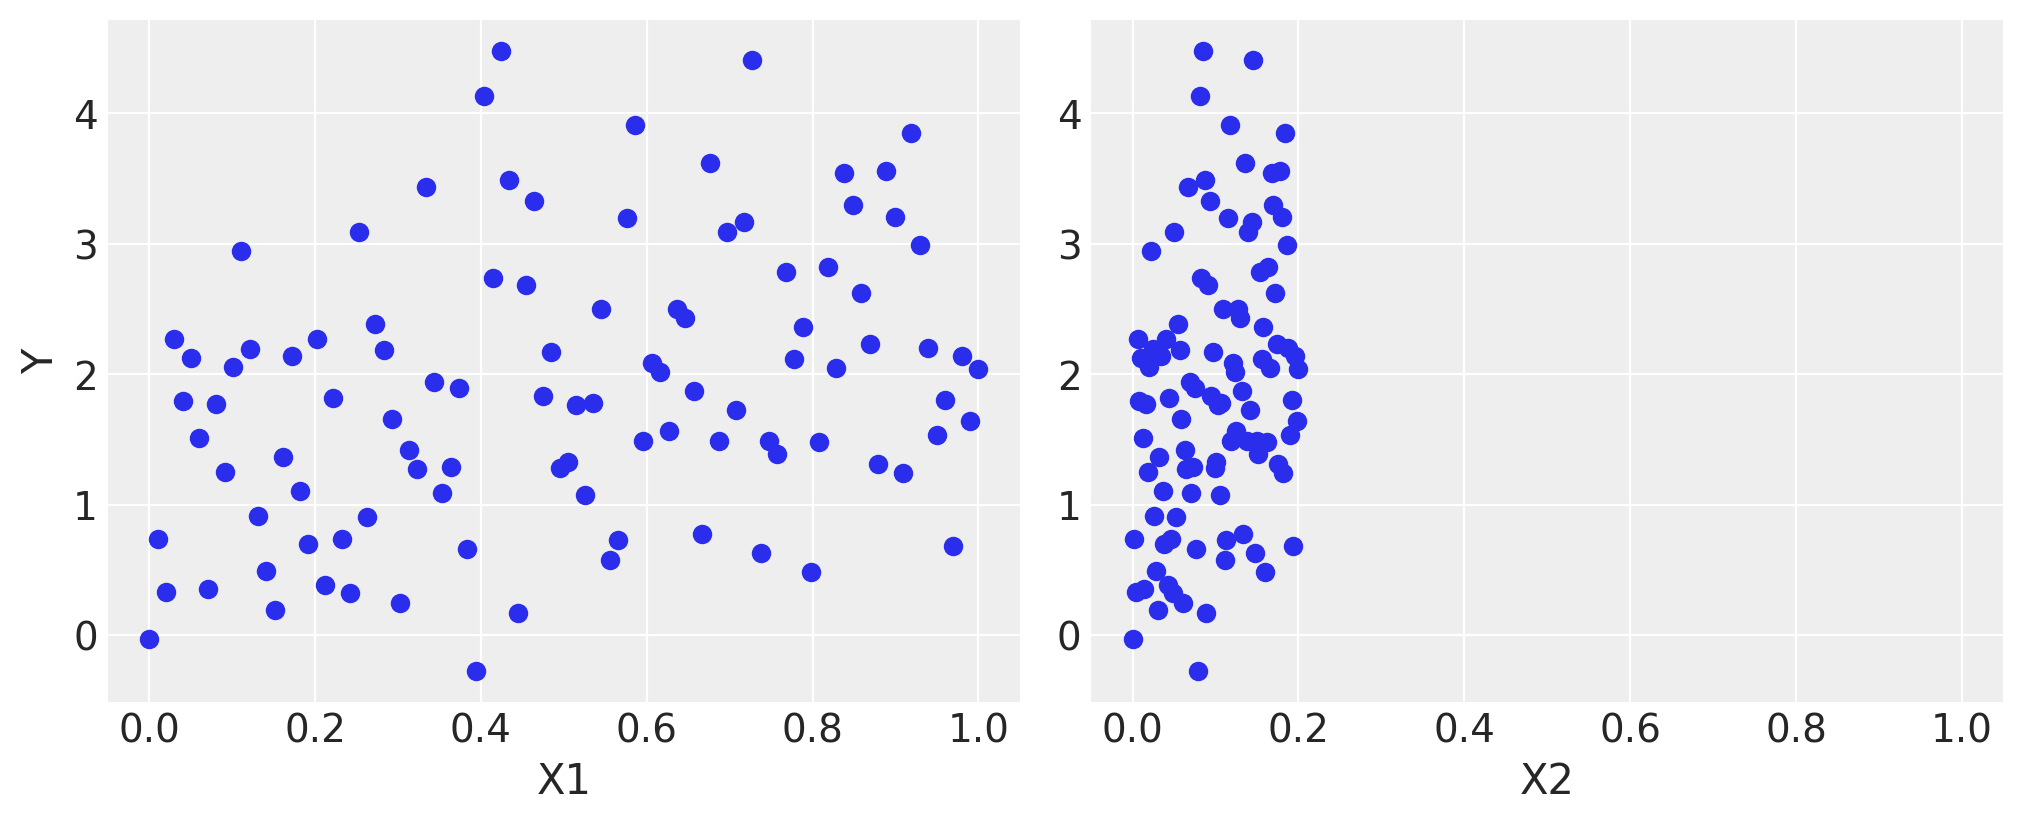

In [ ]:
fig, axes = subplots(1, 2, sharex=True, figsize=(10,4)) 
axes[0].scatter(X1, Y) 
axes[1].scatter(X2, Y) 
axes[0].set_ylabel('Y') 
axes[0].set_xlabel('X1') 
axes[1].set_xlabel('X2')

We choose zero-mean normal priors with variance of 100 for both regression coefficients.  
We choose a half-normal distribution (normal distribution bounded at zero) as the prior for σ.



In [ ]:
from pymc3 import Model, Normal, HalfNormal

In [ ]:
basic_model = Model()

with basic_model:
    #priors for unknown model parameters
    aplha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    #expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    #likelihood (sampling distrbution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y )

# Model fitting 
**Maximum a posteriori methods**

*   The maximum a posteriori (MAP) estimate for a model, is the **mode** of the posterior distribution
*   Only gives a **point estimate** for the parameters and can be biased if the mode isn’t representative of the distribution
*   Most techniques for finding the MAP estimate also only find a local optimium (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully differen



In [ ]:
from pymc3 import find_MAP 
map_estimate = find_MAP(model=basic_model) 
print(map_estimate)


{'alpha': array(0.), 'beta': array([1.49677594, 0.29935519]), 'sigma_log__': array(0.00973711), 'sigma': array(1.00978467)}


In [ ]:

map_estimate = find_MAP(model=basic_model, method="powell") 
print(map_estimate)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning:

Method powell does not use gradient information (jac).




{'alpha': array(4.22560114e-10), 'beta': array([1.50996521, 0.2619208 ]), 'sigma_log__': array(0.00960387), 'sigma': array(1.00965014)}


**Sampling methods**  
Gradient-based sampling methods : PyMC3’s most capable step method is the No-U- Turn Sampler.  

We will use NUTS to sample 2000 draws from
the posterior using the MAP as the starting point and scaling point.

In [ ]:
from pymc3 import NUTS, sample 
with basic_model:
  # obtain starting values via MAP 
  start = find_MAP()
  # instantiate sampler 
  step = NUTS(scaling=start)
  # draw 2000 posterior samples 
  trace = sample(2000, step, start=start)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.


In [ ]:
print(trace[0])
print(trace['alpha'])
print(trace['alpha'][-5:])

{'alpha': -1.8271604596941189, 'beta': array([1.32883172, 1.03240259]), 'sigma_log__': 0.07686066556175025, 'sigma': 1.079891599820128}
[-12.95894042  -7.63293376  10.02909112 ...  -5.68036555   1.08636849
  -8.15775135]
[19.31290583  5.74807816 -5.68036555  1.08636849 -8.15775135]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fe48fb990>,
      dtype=object)

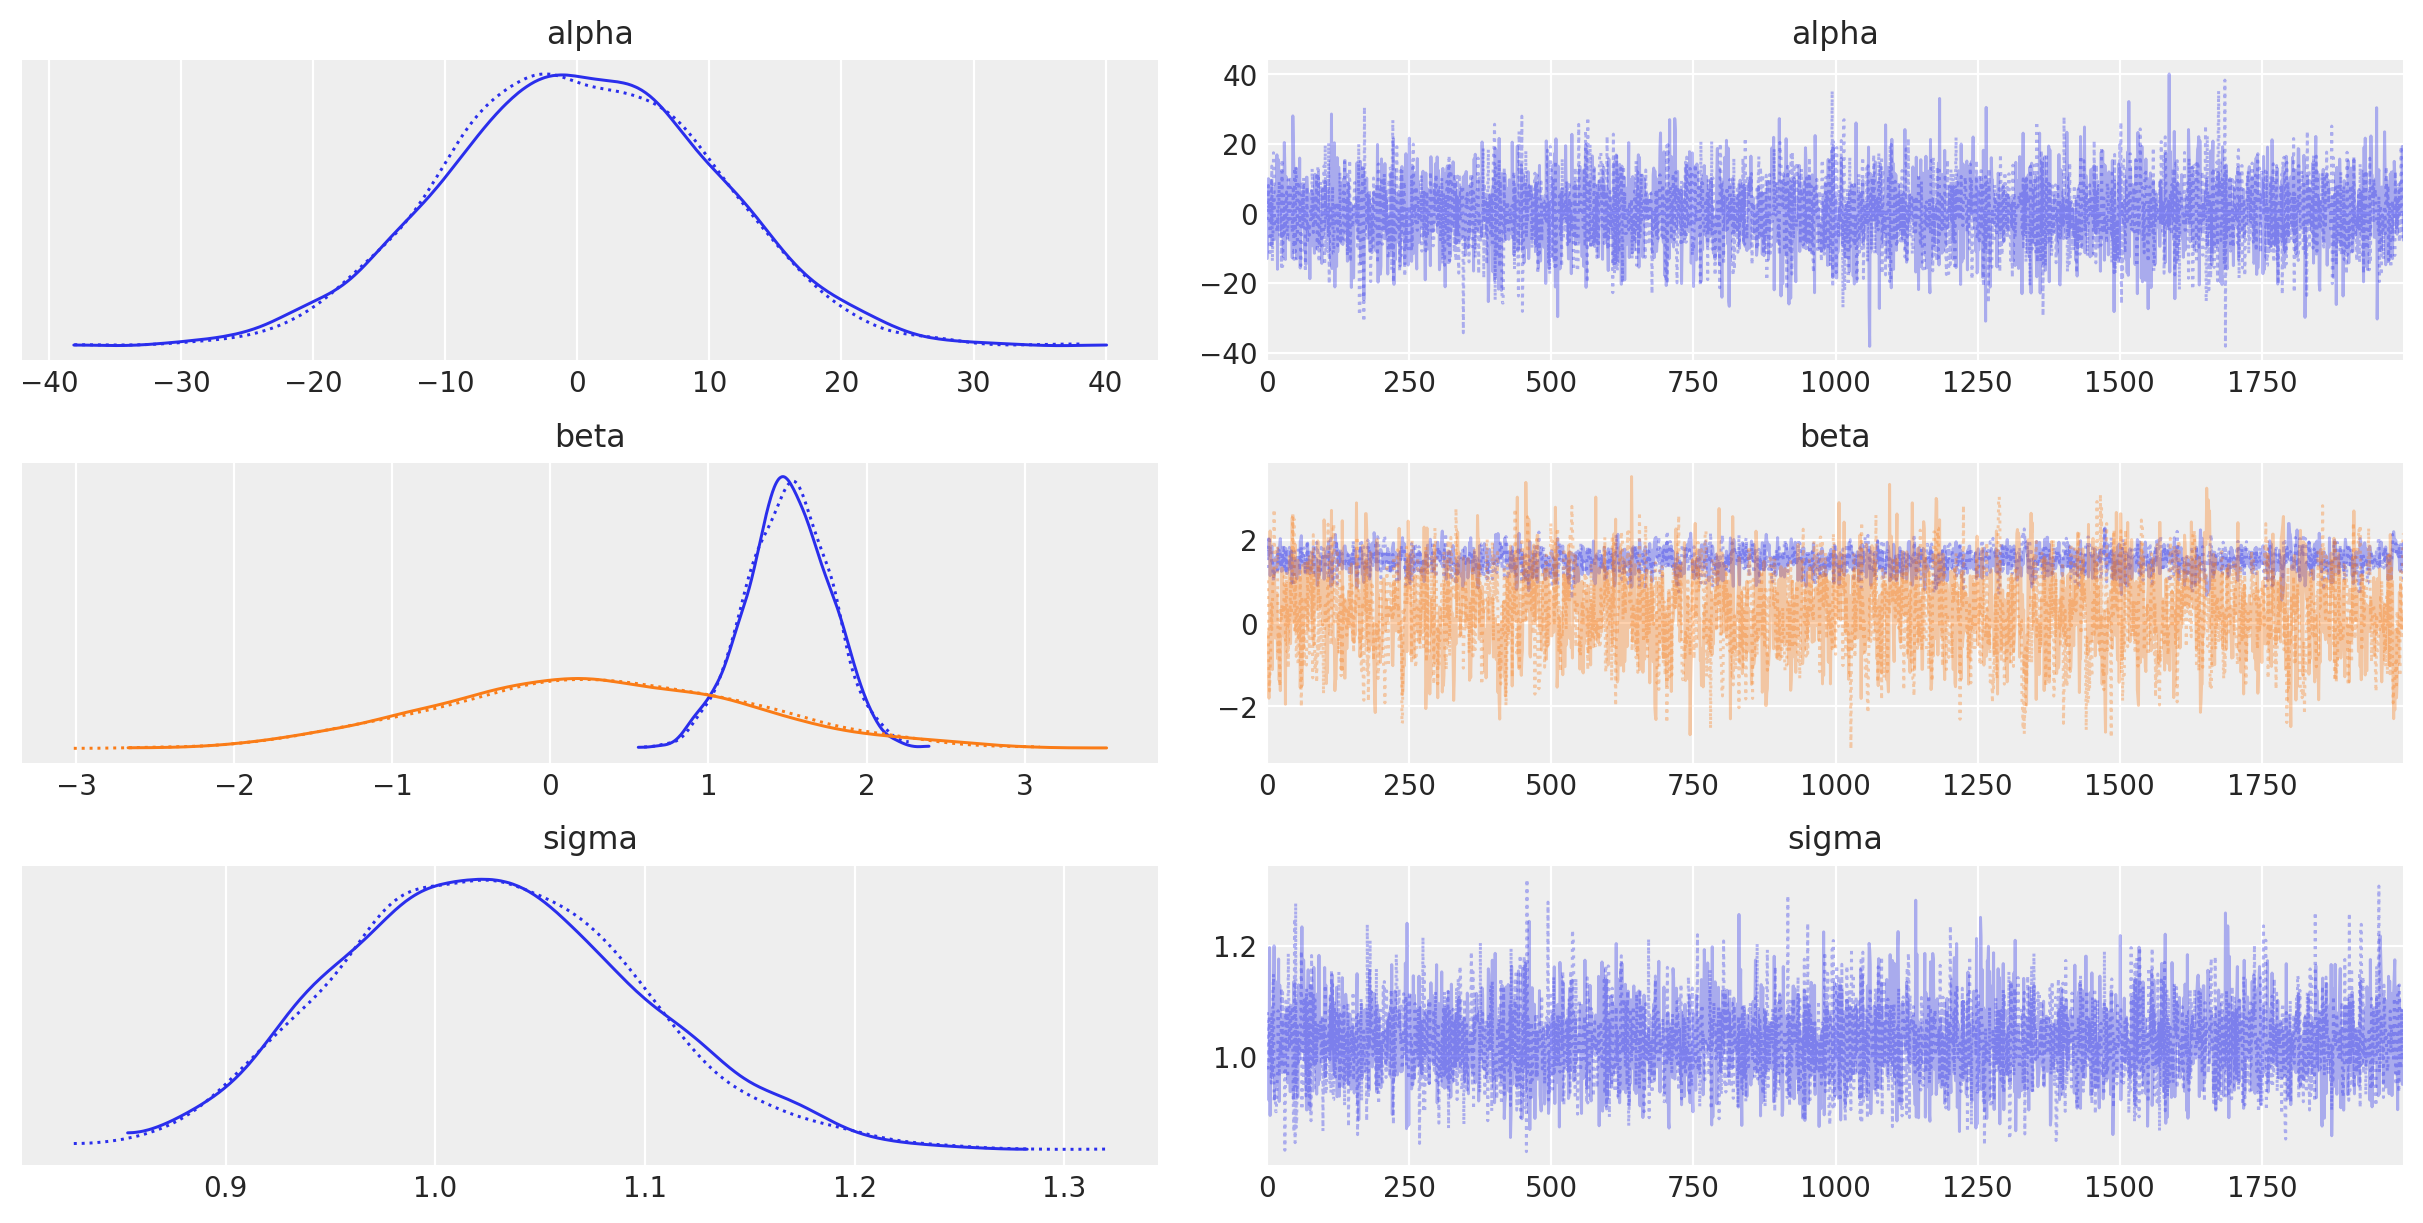

In [ ]:
from pymc3 import traceplot
traceplot(trace)

In [ ]:
from pymc3 import summary
summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.114,10.115,-17.660,20.009,0.138,0.151,5367.0,3368.0,1.0
beta[0],1.501,0.265,0.966,1.969,0.007,0.005,1271.0,2106.0,1.0
beta[1],0.275,0.993,-1.625,2.109,0.028,0.020,1243.0,2045.0,1.0
sigma,1.026,0.072,0.899,1.167,0.001,0.001,5579.0,3206.0,1.0


# Case study 1: Stochastic volatility


In [ ]:
import pandas as pd
returns = pd.read_csv(
    pm.get_data("SP500.csv"), parse_dates=True, index_col=0, usecols=["Date", "change"]
)
len( returns)

2906

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:21: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 



Text(0, 0.5, 'daily returns in %')

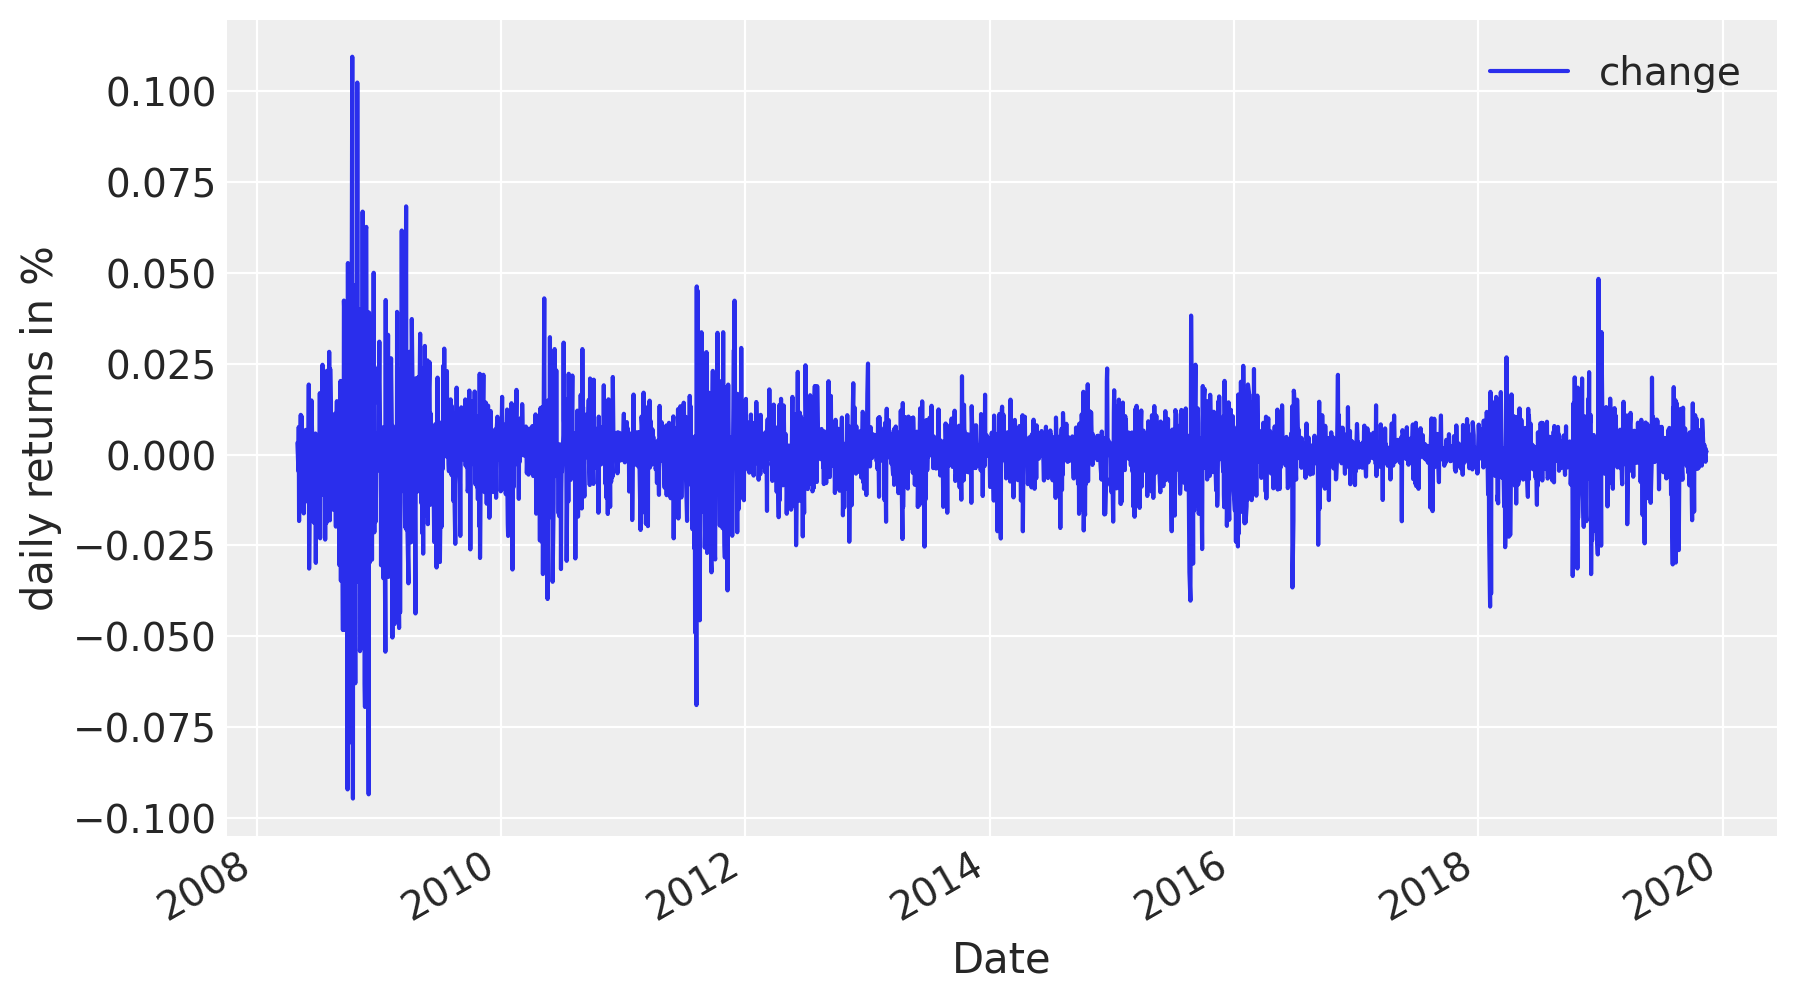

In [ ]:
returns.plot(figsize=(10, 6))
plt.ylabel("daily returns in %")

In [ ]:
from pymc3 import Exponential, StudentT, Deterministic 
from pymc3.distributions.timeseries import GaussianRandomWalk
with Model() as sp500_model:
  nu = Exponential('nu', 1./10, testval=.1) 
  sigma = Exponential('sigma', 1./.02, testval=.1) 
  s = GaussianRandomWalk('s', sigma**-2, shape=400) 
  volatility_process = Deterministic('volatility_process', exp(-2*s)) 
  r = StudentT('r', nu, lam=1/volatility_process, observed=returns)


In [ ]:
import scipy 
with sp500_model: 
  start = find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)
  step = NUTS(scaling=start) 
  trace = sample(50, step, progressbar=False)
# Start next run at the last sampled position. 
  step = NUTS(scaling=trace[-1], gamma=.25) 
  trace = sample(2000, step, start=trace[-1],progressbar=False, njobs=4)


NameError: ignored

In [ ]:
with sp500_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, sigma, nu]


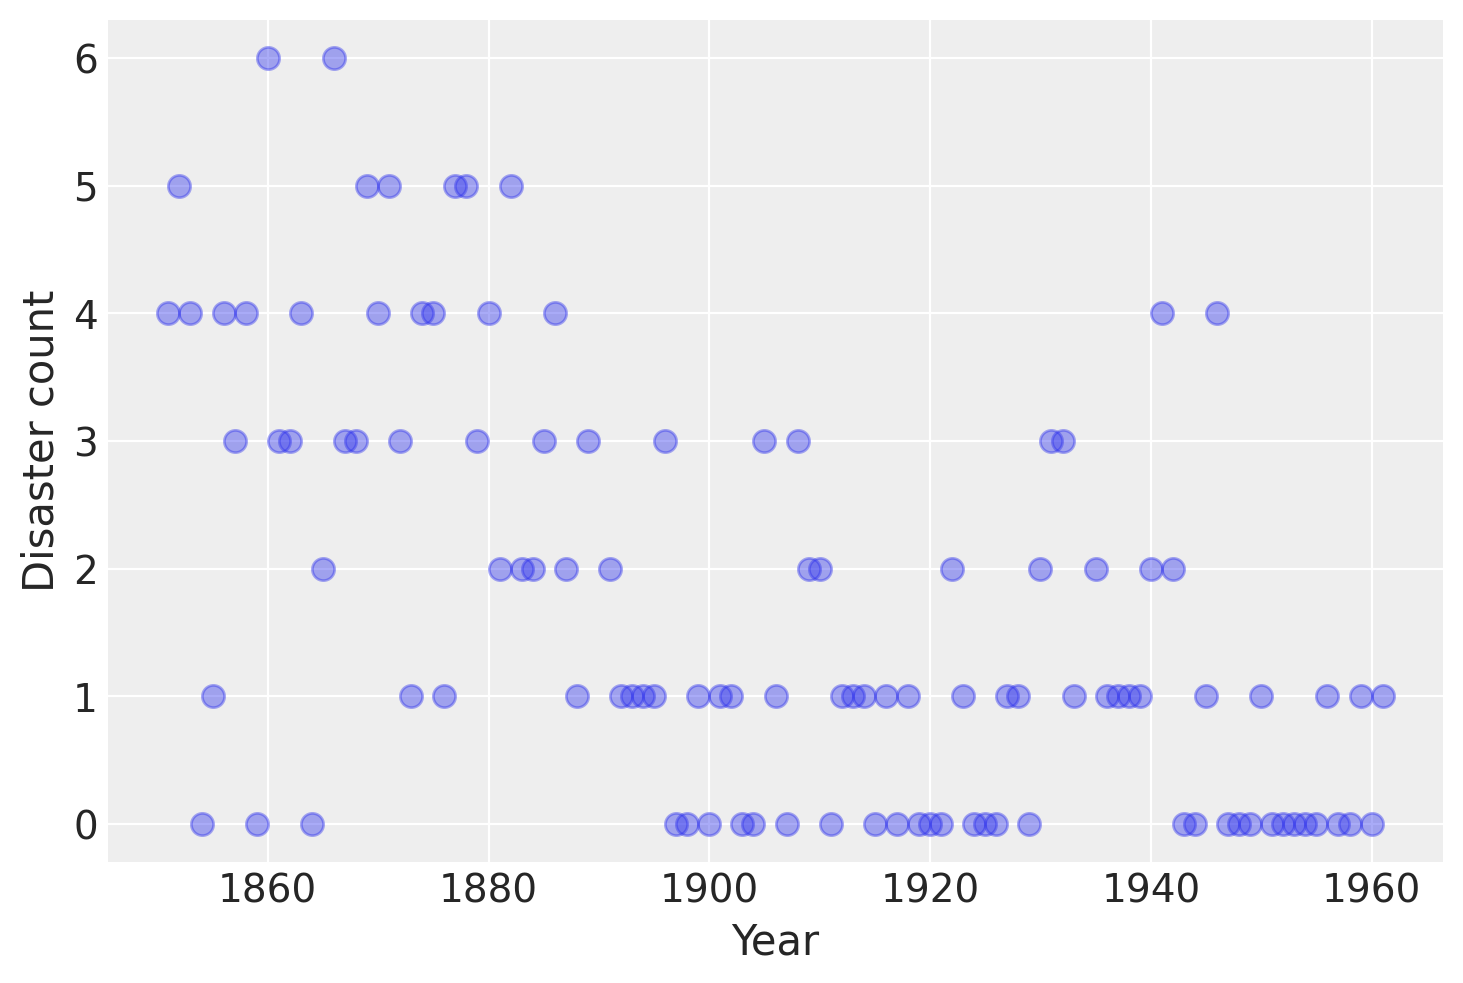

In [ ]:
import pandas as pd

# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [ ]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900
    )

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)#switch, a Theano function that works like an if statement. It uses the first argument to switch between the next two arguments.

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning:

Data in disasters contains missing values and will be automatically imputed from the sampling distribution.



In [ ]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46490a5b90>,
      dtype=object)

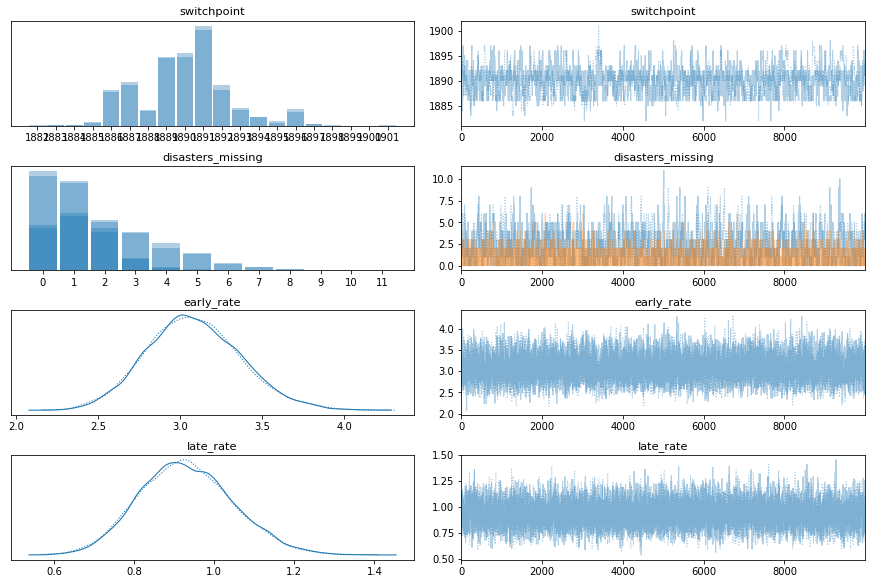

In [ ]:
traceplot(trace)

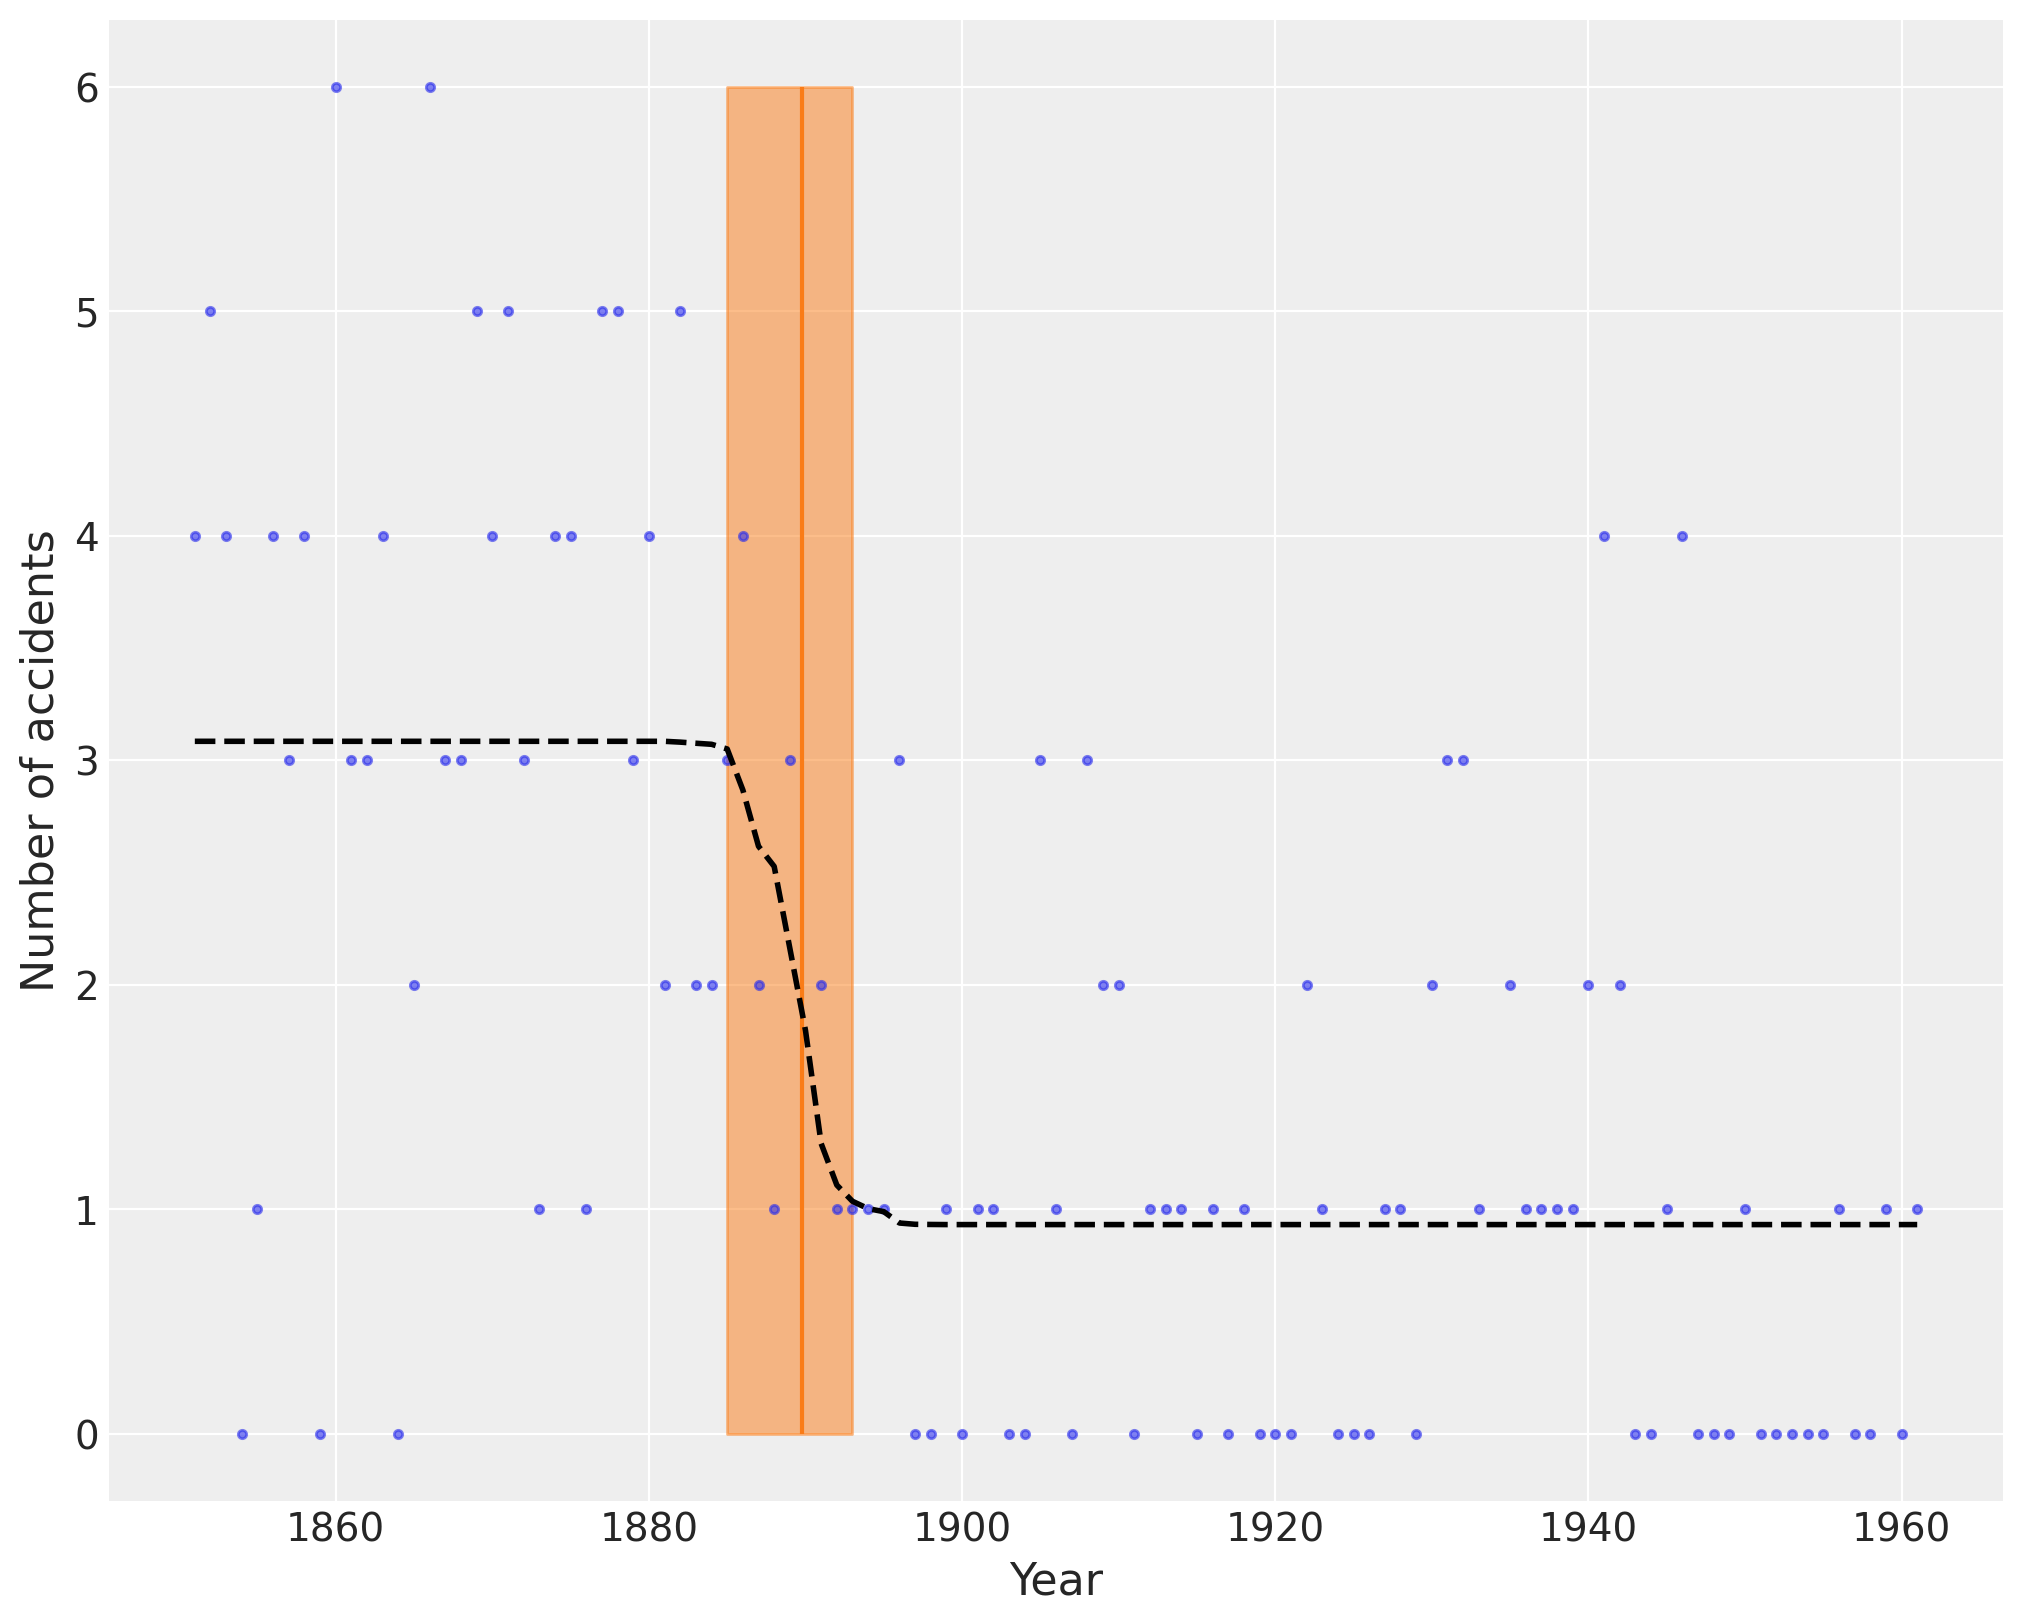

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);